In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
#Tensorflow libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [2]:
data_dir = 'datasets/train'
data_dir = pathlib.Path(data_dir)

data_dir

PosixPath('datasets/train')

In [3]:
#get image count
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Total Images:",image_count)

Total Images: 3781


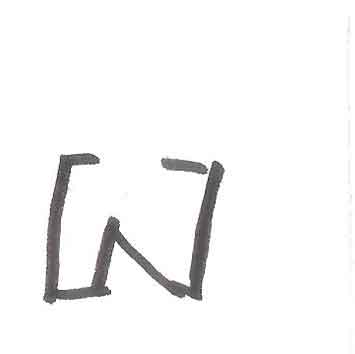

In [4]:
#get all images in ba file 
ba_letter = list(data_dir.glob('ba/*'))
# show third image 
PIL.Image.open(str(ba_letter[3]))

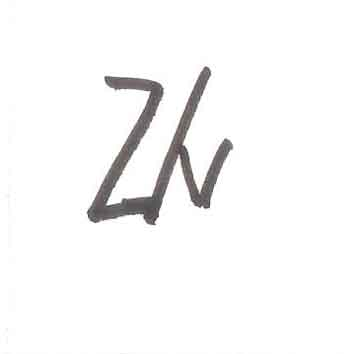

In [5]:
#get all images in ya file
ya_letter = list(data_dir.glob('ya/*'))
PIL.Image.open(str(ya_letter[3]))

In [6]:
# Batch size
batch_size = 32
# image height
img_height = 180
# image width
img_width = 180

In [13]:
# split dataset for train
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3782 files belonging to 18 classes.
Using 3026 files for training.


In [14]:
# split dataset for validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3782 files belonging to 18 classes.
Using 756 files for validation.


In [15]:
#get class names
class_names = train_ds.class_names
print(class_names)

['ba', 'ca', 'da', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'wa', 'ya']


2024-05-23 05:39:43.142894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


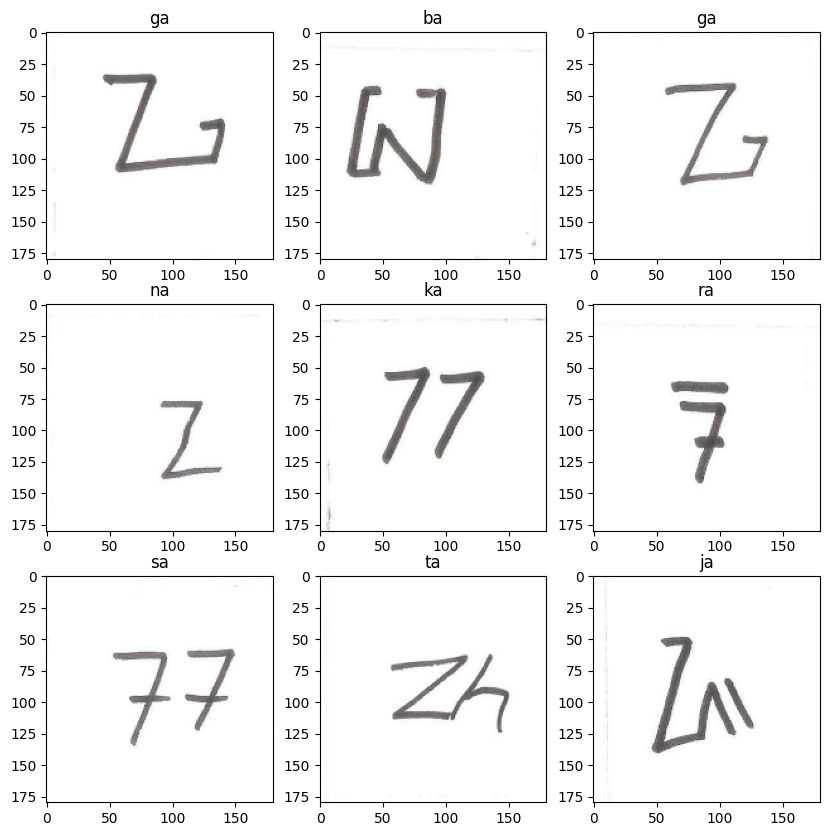

In [16]:
# determine figure size as 10 by 10
plt.figure(figsize=(10, 10))
# take image from train_ds
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # plot image using imshow
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])

In [17]:
# print shape img
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [18]:
#Create autotune object
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
# Create a normalization layer
normalization_layer = layers.Rescaling(1./255)

In [20]:
#normalize dataser using with norm. layer
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# sparete as image and label
image_batch, labels_batch = next(iter(normalized_ds))
# check the first image max and min value
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print("minumum value:",np.min(first_image), "maximum values: ",np.max(first_image))

minumum value: 0.25890756 maximum values:  1.0


In [22]:
# get class names
num_classes = len(class_names)

# build model layers
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [23]:
#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,990,962 (15.22 MB)

 Trainable params: 3,990,962 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Train the model for 10 epochs with the Keras 

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 33s 337ms/step - accuracy: 0.0907 - loss: 3.0087 - val_accuracy: 0.3611 - val_loss: 2.1056
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 30s 313ms/step - accuracy: 0.4398 - loss: 1.8152 - val_accuracy: 0.5714 - val_loss: 1.3641
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 31s 322ms/step - accuracy: 0.7224 - loss: 0.9311 - val_accuracy: 0.7460 - val_loss: 0.9725
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 29s 303ms/step - accuracy: 0.8777 - loss: 0.3865 - val_accuracy: 0.8069 - val_loss: 0.7220
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 31s 326ms/step - accuracy: 0.9609 - loss: 0.1453 - val_accuracy: 0.8320 - val_loss: 0.6255
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 38s 399ms/step - accuracy: 0.9873 - loss: 0.0577 - val_accuracy: 0.8399 - val_loss: 0.7212
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 32s 334ms/step - accuracy: 0.9944 - loss: 0.0287 - val_accuracy: 0.8585 - val_loss: 0.7898
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 31s 328ms/step - accuracy: 0.9971 - loss: 0.0182 - val_accu

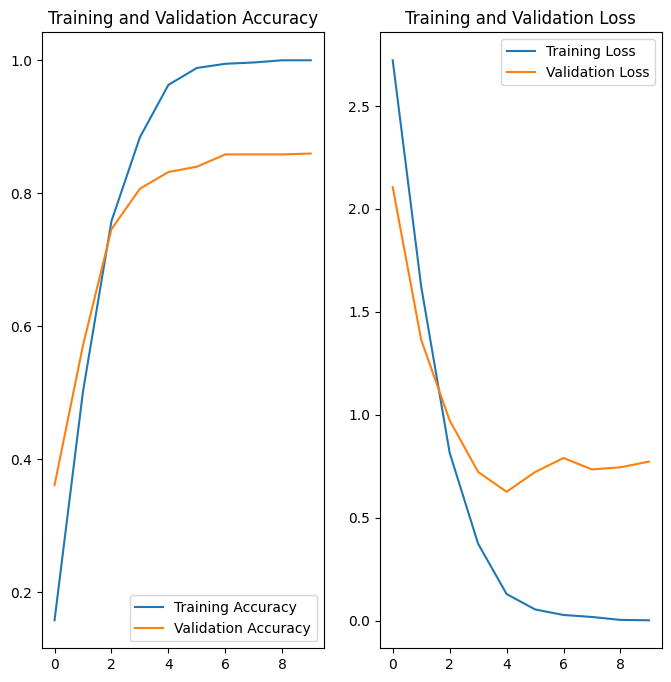

In [26]:
#get train accuracy in history
acc = history.history['accuracy']
#get validation accuracy
val_acc = history.history['val_accuracy']
# get train loss 
loss = history.history['loss']
#get validation loss
val_loss = history.history['val_loss']

epochs_range = range(epochs)
# plot accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
# create augmentation sequentions
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

2024-05-23 05:45:28.295245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


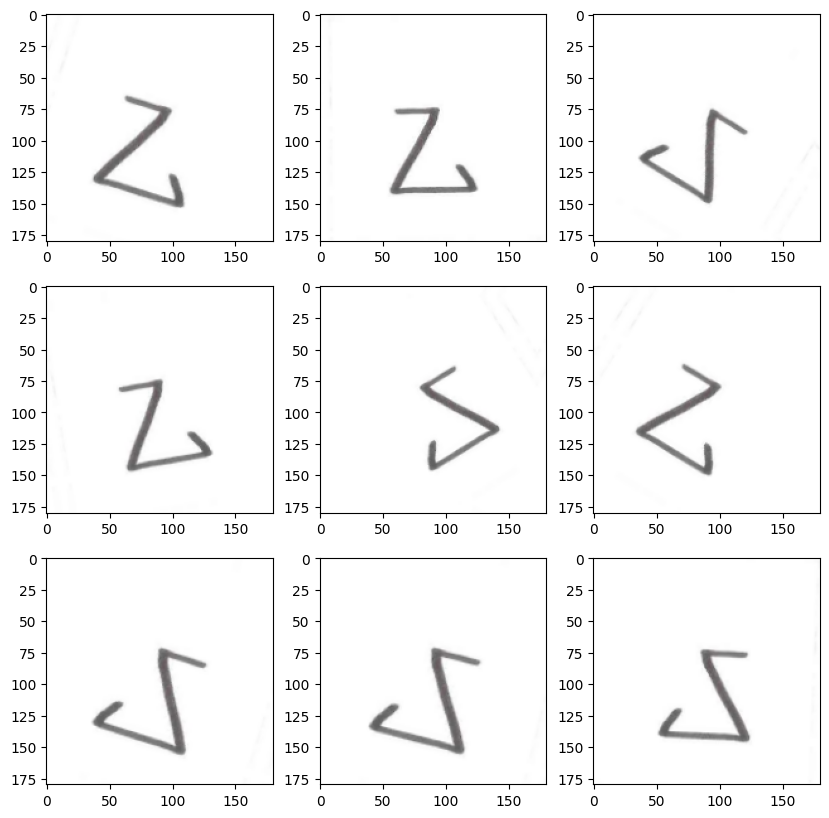

In [28]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("on")

In [29]:
# Create neural network with tf.keras.layers.Dropout before training it using the augmented images
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 38s 390ms/step - accuracy: 0.0591 - loss: 3.0232 - val_accuracy: 0.0556 - val_loss: 2.8909
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 34s 357ms/step - accuracy: 0.0598 - loss: 2.8904 - val_accuracy: 0.0463 - val_loss: 2.8914
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 34s 357ms/step - accuracy: 0.0615 - loss: 2.8903 - val_accuracy: 0.0463 - val_loss: 2.8919
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 36s 381ms/step - accuracy: 0.0613 - loss: 2.8905 - val_accuracy: 0.0476 - val_loss: 2.8916
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 36s 380ms/step - accuracy: 0.0584 - loss: 2.8925 - val_accuracy: 0.0582 - val_loss: 2.8917
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 36s 384ms/step - accuracy: 0.0624 - loss: 2.8905 - val_accuracy: 0.0463 - val_loss: 2.8926
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 40s 419ms/step - accuracy: 0.0601 - loss: 2.8905 - val_accuracy: 0.1429 - val_loss: 2.8116
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 34s 360ms/step - accuracy: 0.1756 - loss: 2.7004 - val_accu

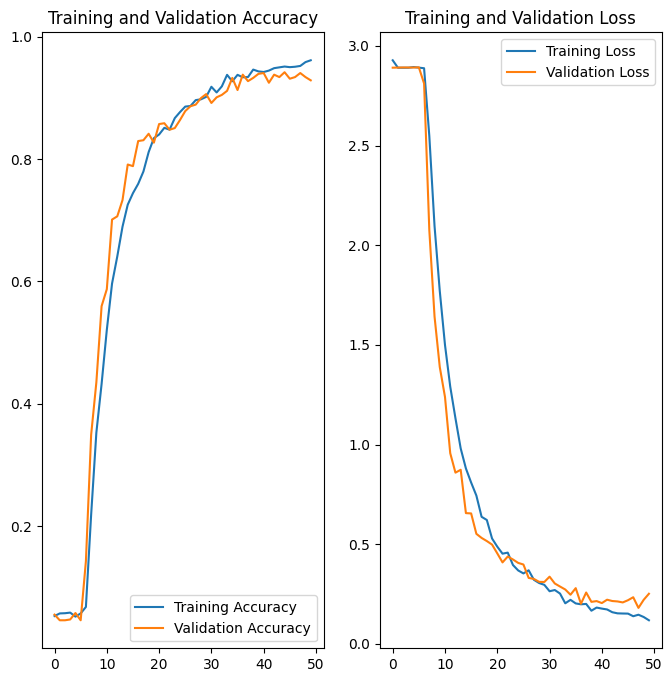

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
# get image from local path
image = 'Ba.jpg'
image = tf.keras.utils.load_img(image, target_size=(img_height,img_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)

In [34]:
#make prediction
predictions = model.predict(img_bat)
#get score
score = tf.nn.softmax(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


In [35]:
print('Huruf ini termasuk kedalam {} dengan akurasi {:0.2f}'.format(class_names[np.argmax(score)],np.max(score)*100))

Huruf ini termasuk kedalam ba dengan akurasi 82.30


In [36]:
#image url
img_url = "https://upload.wikimedia.org/wikipedia/commons/0/0a/Sunda_Ba.png"
#dowload image
img_path = tf.keras.utils.get_file('Image_letter', origin=img_url)
#load image
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
# image to array
img_array = tf.keras.utils.array_to_img(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

#make prediction
predictions = model.predict(img_array)
#get score
score = tf.nn.softmax(predictions[0])

print('Huruf ini termasuk kedalam {} dengan akurasi {:0.2f}'.format(class_names[np.argmax(score)],np.max(score)*100))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Huruf ini termasuk kedalam sa dengan akurasi 100.00


In [37]:
model.save('ImageClassification.keras')